In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Approche classique: embeddings de mots

In [ ]:
import pandas as pd

In [2]:
train_df = pd.read_csv("./data/train_df.csv", index_col=0)
test_df = pd.read_csv("./data/test_df.csv", index_col=0)

In [3]:
train_df.shape

(103557, 7)

In [4]:
test_df.shape

(44382, 7)

In [5]:
y_train = train_df["target"]
y_test = test_df["target"]

### Embeddings de comptage des mots

En réalisant les embeddings de façon indépendante sur le jeu de train et de test on s'assure qu'il n'y a pas de fuite de données et que l'appréciation de performance du modèle ne sera pas biaisée. Cependant il y a un fort risque d'avoir des OOV lors du test.

#### CountVectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
train_count_sparse = count_vectorizer.fit_transform(train_df['cleaned_text'])

test_count_sparse = count_vectorizer.transform(test_df['cleaned_text'])


In [7]:
# # Précaution à prendre avec les matrices creuses
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(with_mean=False)
# train_count_scaled = scaler.fit_transform(train_count_sparse)
# test_count_scaled = scaler.fit_transform(test_count_sparse)

In [8]:
import scipy.sparse

train_count = pd.DataFrame.sparse.from_spmatrix(train_count_sparse, columns=count_vectorizer.get_feature_names_out())

test_count = pd.DataFrame.sparse.from_spmatrix(test_count_sparse, columns=count_vectorizer.get_feature_names_out())



In [9]:
from scipy.sparse import csr_matrix, hstack
train_count["target"] = y_train.values
test_count["target"] = y_test.values

### Modélisation des embeddings : test rapides avec Pycaret

In [ ]:
pip install pycaret[full]

In [ ]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(data=train_count, target='target', test_data=test_count, session_id = 123, index=False, use_gpu=True)


In [12]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()


In [13]:
# check the type of exp A CHANGER POUR MLFLOW à ce moment là le setup se fait avec 
type(exp)
# exp.setup(data, target = 'Class variable', session_id = 123)

pycaret.classification.oop.ClassificationExperiment

In [14]:
# compare baseline models
best_model = compare_models(sort='Precision')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:59:38
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,SVM - Linear Kernel


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7805,0.8525,0.7948,0.7714,0.7829,0.5611,0.5614,62.7840
dt,Decision Tree Classifier,0.7037,0.7036,0.6985,0.7041,0.7013,0.4073,0.4074,90.1900
knn,K Neighbors Classifier,0.6554,0.7166,0.7802,0.6231,0.6928,0.3116,0.3219,92.8900


Processing:   0%|          | 0/69 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
# On peut directement suivre cette première intuition en fine-tunant le meilleur modèle
tuned_model = tune_model(estimator=best_model, 
                         optimize="Precision", choose_better=True,
                         verbose=False)

In [ ]:
plot_model(tuned_model, plot="parameter")

In [37]:
et = create_model("et")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7510,0.8254,0.7481,0.7510,0.7495,0.5019,0.5019
1,0.7230,0.7964,0.7054,0.7295,0.7172,0.4459,0.4461
2,0.7432,0.8096,0.7364,0.7451,0.7407,0.4865,0.4865
3,0.7548,0.8281,0.7248,0.7695,0.7465,0.5095,0.5104
4,0.7625,0.8403,0.7519,0.7668,0.7593,0.5251,0.5252
5,0.7498,0.8219,0.7456,0.7500,0.7478,0.4995,0.4995
6,0.7623,0.8324,0.7612,0.7612,0.7612,0.5246,0.5246
7,0.7536,0.8260,0.7670,0.7453,0.7560,0.5073,0.5075
8,0.7594,0.8258,0.7578,0.7592,0.7585,0.5188,0.5188


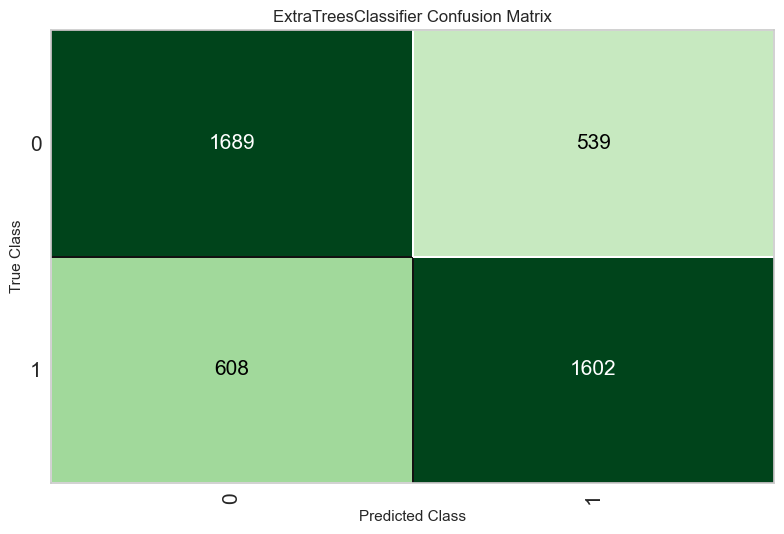

In [38]:
# plot confusion matrix
plot_model(et, plot = 'confusion_matrix')

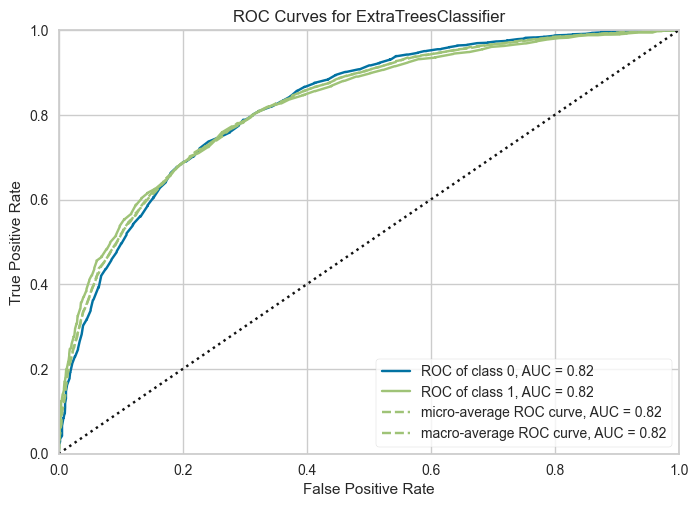

In [39]:
plot_model(et)

In [ ]:
# plot_model(et, plot = 'boundary') # Erreur sur les matrices creuses, même en normalisant.

In [45]:
tuned_et = tune_model(et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6959,0.7656,0.8120,0.6578,0.7268,0.3924,0.4036
1,0.6853,0.7420,0.7636,0.6589,0.7074,0.3710,0.3758
2,0.7017,0.7728,0.8062,0.6656,0.7292,0.4040,0.4132
3,0.6805,0.7586,0.8120,0.6417,0.7169,0.3616,0.3750
4,0.7046,0.7784,0.8372,0.6606,0.7385,0.4099,0.4252
5,0.6676,0.7384,0.7903,0.6330,0.7029,0.3360,0.3468
6,0.6957,0.7588,0.7786,0.6661,0.7180,0.3918,0.3974
7,0.6792,0.7567,0.8252,0.6372,0.7191,0.3593,0.3759
8,0.7053,0.7638,0.8023,0.6710,0.7308,0.4110,0.4190


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [41]:
pred_holdouts = predict_model(et)
pred_holdouts.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7416,0.8243,0.7249,0.7482,0.7364,0.4830,0.4833


,01,02,021,03,04,05,05m,06,060409,074276571,...,zutons,zwart,zz,zzs,zzzz,zzzzz,zzzzzz,target,prediction_label,prediction_score
10355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6900
10356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9100
10357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.5675
10358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6700
10359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6800


In [46]:
best = automl(optimize = 'Precision')
best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [75]:
# Finalize the model (train on the entire dataset)
finalize_model(best)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['01', '02', '021', '03', '04',
                                             '05', '05m', '06', '060409',
                                             '074276571', '0752', '08', '09',
                                             '0dt', '0ga', '0ut', '10', '101',
                                             '103', '1030', '105', '10am',
                                             '10h', '10ish', '10lb', '10pm',
                                             '10s', '10th', '12', '120', ...],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='sqrt',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      monotonic_cst=None, n_estimators=100,
                                      n_jobs=-1, oob_score=False,
                                      random_state=123, verbose=0,
                                      warm_start=False))],
         verbose=False)

In [74]:
# save_model(best, model_name='CountVectorizer_Best_Model')

import os
from datetime import date, datetime

os.chdir("C:/users/Cecil/Documents/oc_aiep7")
PATH = os.getcwd()+os.sep
current_time = datetime.now().strftime("%m-%d-%Y_%H-%M")
save_model(best, PATH + "models" + os.sep + "best_model_CountVectorizer_" + current_time)


# loaded_bestmodel = load_model('CountVectorizer_Best_Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['01', '02', '021', '03', '04',
                                              '05', '05m', '06', '060409',
                                              '074276571', '0752', '08', '09',
                                              '0dt', '0ga', '0ut', '10', '101',
                                              '103', '1030', '105', '10am',
                                              '10h', '10ish', '10lb', '10pm',
                                              '10s', '10th', '12', '120', ...],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                      

#### TFIdF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 2,max_df = 0.5,ngram_range = (1,2))
train_tfidf_sparse = tfidf.fit_transform(train_df['cleaned_text'])
test_tfidf_sparse = tfidf.transform(test_df['cleaned_text'])

In [84]:
import scipy.sparse
train_tfidf = pd.DataFrame.sparse.from_spmatrix(train_tfidf_sparse, columns=TfidfVectorizer.get_feature_names_out())
test_tfidf = pd.DataFrame.sparse.from_spmatrix(test_tfidf_sparse, columns=TfidfVectorizer.get_feature_names_out())

In [85]:
from scipy.sparse import csr_matrix, hstack
train_tfidf["target"] = y_train.values
test_tfidf["target"] = y_test.values

In [86]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(data=train_tfidf, target='target', test_data=test_tfidf, session_id = 123, index=False)


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(147939, 48593)"
4,Transformed data shape,"(147939, 48593)"
5,Transformed train set shape,"(103557, 48593)"
6,Transformed test set shape,"(44382, 48593)"
7,Numeric features,48592
8,Preprocess,True
9,Imputation type,simple


In [87]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()


In [88]:
# check the type of exp A CHANGER POUR MLFLOW à ce moment là le setup se fait avec 
type(exp)
# exp.setup(data, target = 'Class variable', session_id = 123)

pycaret.classification.oop.ClassificationExperiment

In [ ]:
# compare baseline models
best_model = compare_models(sort='Precision')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:09:31
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


Processing:   0%|          | 0/65 [00:00<?, ?it/s]